# Download model from S3, compile and deploy

In [1]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base
from sagemaker import get_execution_role 


In [2]:
role = get_execution_role() 
sess = sagemaker.Session()
region = sess.boto_region_name
account = sess.boto_session.client('sts').get_caller_identity()['Account']
bucket = sess.default_bucket()
prefix = 'pretrained-mobilenet-mxnet'

image_url = '301217895009.dkr.ecr.us-west-2.amazonaws.com/sagemaker-neo-mxnet:1.4.1-cpu-py3'

## Download pretrained mobilenet model

In [3]:
from sagemaker.mxnet.model import MXNetModel
from sagemaker.predictor import RealTimePredictor

mobilenet_model = MXNetModel(
    # insert model path below
    model_data='s3://sagemaker-us-west-2-404488442729/pretrained-mobilenet/pretrained.tar.gz',
    image=image_url,
    entry_point='entry_point.py',
    predictor_cls=RealTimePredictor,
    role=role,
    sagemaker_session=sess,
    py_version='py3',
    framework_version='1.4.1'
)

## Compile pretrained model
Refer to https://sagemaker.readthedocs.io/en/stable/model.html without a entry_point.py file

In [4]:
output_path = 's3://{}/{}/test/output'.format(bucket, prefix)
compiled_mobilenet = mobilenet_model.compile(target_instance_family='ml_c5', 
                                         input_shape={'data':[1,3,512,512]},
                                         job_name='complied-pretrained-mobilenet-mxnet22',
                                         role=role,
                                         framework='mxnet',
                                         output_path=output_path)

?.......!

## Deploy compiled model

In [6]:
compiled_mobilenet.image = image_url
compiled_mobilenet.name = 'deploy-pretrained-mobilenet-mxnet-ssd-test1'
object_detector = compiled_mobilenet.deploy(initial_instance_count = 1,
                                            instance_type = 'ml.c5.xlarge',
                                            #endpoint_name = 'deploy-pretrained-mobilenet-mxnetml-c5',
                                            #update_endpoint = True
                                           )

Using already existing model: deploy-pretrained-mobilenet-mxnet-ssd-test1ml-c5


-------------------------------------------------------------------------------------!

## Inference
### Prepare input - Image pre-processing
First convert image to byte array, then invoke entry point convert byte array back to PIL.Image readable file, after that, resize to required input size and convert to ndarray for future use.

In [7]:
import json
import numpy as np

file_name = "test.jpg"

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload) 


### Inference with endpoint

In [8]:
%%time
object_detector.content_type = 'image/jpeg'
response = object_detector.predict(payload)
detections = json.loads(response)

CPU times: user 15.4 ms, sys: 4.81 ms, total: 20.2 ms
Wall time: 827 ms


In [9]:
print(detections)

{'prediction': [[13.0, 0.9988179802894592, 0.2263159155845642, 0.6181575655937195, 0.45466357469558716, 0.8477267622947693], [13.0, 0.9966952800750732, 0.4989623427391052, 0.6103203296661377, 0.6792760491371155, 0.7892043590545654], [13.0, 0.995415449142456, -0.0032107755541801453, 0.6066834926605225, 0.17556098103523254, 0.8503793478012085], [13.0, 0.954442024230957, 0.7130578756332397, 0.5932590961456299, 0.8780719041824341, 0.7741299867630005], [14.0, 0.8552682399749756, 0.2830899655818939, 0.5063178539276123, 0.38040855526924133, 0.8031598329544067], [14.0, 0.42335256934165955, 0.508553147315979, 0.4864584803581238, 0.5802133083343506, 0.7117454409599304], [14.0, 0.4096168875694275, 0.7556367516517639, 0.5158030986785889, 0.8294792771339417, 0.717574954032898], [14.0, 0.2636711597442627, 0.3817487061023712, 0.5834391117095947, 0.44478538632392883, 0.7973055839538574], [14.0, 0.23079466819763184, 0.29255616664886475, 0.5036441087722778, 0.3561175465583801, 0.6726640462875366], [13.0

### Visualize output

In [10]:
%matplotlib inline
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        from matplotlib.patches import Rectangle

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin-2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

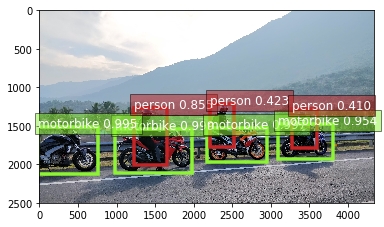

In [11]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                     'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
file_name = "test.jpg"
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.40

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)